## Setting Up

### Installing Dependencies

In [17]:
%pip install openai pydantic instructor pandas matplotlib networkx python-dotenv
from IPython.display import clear_output ; clear_output()

### Loading Azure Open AI configuration

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
GPT_4_O_MODEL_NAME = os.getenv("GPT_4_O_MODEL_NAME", default="gpt-4o")

from openai import AzureOpenAI

aoai = AzureOpenAI(
    api_version="2024-05-01-preview",
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
)

## Using Structured Input/Output with OpenAI

In [18]:
import instructor
from pydantic import BaseModel, Field
from typing import List
from enum import Enum
import json
from pandas import DataFrame
import networkx as nx
import matplotlib.pyplot as plt


client = instructor.from_openai(aoai)

def print_json(data):
    print(json.dumps(data, indent=2))

def print_schema(model: BaseModel):
    print_json(model.model_json_schema(), indent=2)

def print_result(result: BaseModel):
    print(result.model_dump_json(indent=2))

def json_dataframe(data):
    return DataFrame([item.dict() for item in data])

def llm(response_model: BaseModel = BaseModel, system: str = None, user: str = None):
    messages = []
    if system:
        messages.append({"role": "system", "content": system})
    if user:
        messages.append({"role": "user", "content": user})
    result = client.chat.completions.create(
        model=GPT_4_O_MODEL_NAME,
        response_model=response_model,
        messages=messages,
    )
    return result

## Working with Text

### Translation and Normalization

In [5]:
class TranslatedString(BaseModel):
    input_language: str = Field(..., description="The language of the original text, as 2-letter language code.")
    translation: str

translation = llm(
    TranslatedString,
    "Detect the language of the original text and translate it into English.",
    "Sprachkenntnisse sind ein wichtiger Bestandteil der Kommunikation.",
)

print_result(translation)

{
  "input_language": "de",
  "translation": "Language skills are an important part of communication."
}


In [6]:
class Translation(BaseModel):
    language: str = Field(..., description="The language of the translated text, as 2-letter language code.")
    translation: str

class Translations(BaseModel):
    translations: List[Translation]

target_languages = ["de", "fr", "it", "es", "he"]

translations = llm(
    Translations,
    f"Translate the user-provided text into the following languages: {json.dumps(target_languages)}",
    "Large Language Models are a powerful tool for natural language processing.",
)

print_result(translations)

{
  "translations": [
    {
      "language": "de",
      "translation": "Große Sprachmodelle sind ein leistungsstarkes Werkzeug für die Verarbeitung natürlicher Sprache."
    },
    {
      "language": "fr",
      "translation": "Les grands modèles de langage sont un outil puissant pour le traitement du langage naturel."
    },
    {
      "language": "it",
      "translation": "I grandi modelli di linguaggio sono uno strumento potente per l'elaborazione del linguaggio naturale."
    },
    {
      "language": "es",
      "translation": "Los modelos de lenguaje grandes son una herramienta poderosa para el procesamiento del lenguaje natural."
    },
    {
      "language": "he",
      "translation": "מודלי שפה גדולים הם כלי עוצמתי לעיבוד שפה טבעית."
    }
  ]
}


In [7]:

text_styles = ["formal", "informal", "casual", "academic", "professional", "business"]

class NormalizedText(BaseModel):
    style: str = Field(
        ...,
        description=(f"The style of the text normalization.  Options: {json.dumps(text_styles)}"))
    text: str

class NormalizedTexts(BaseModel):
    normalized_texts: List[NormalizedText]

normalizations = llm(
    NormalizedTexts,
    f"Normalize the user-provided text into the following styles: {json.dumps(text_styles)}",
    "Large Language Models are a powerful tool for natural language processing.",
)

print_result(normalizations)

{
  "normalized_texts": [
    {
      "style": "formal",
      "text": "Large Language Models are a powerful tool for natural language processing."
    },
    {
      "style": "informal",
      "text": "Large Language Models are a powerful tool for natural language processing."
    },
    {
      "style": "casual",
      "text": "Large Language Models are a powerful tool for natural language processing."
    },
    {
      "style": "academic",
      "text": "Large Language Models represent a significant advancement in the field of natural language processing, providing robust capabilities for a wide range of applications."
    },
    {
      "style": "professional",
      "text": "Large Language Models are a robust tool for natural language processing, enabling sophisticated data analysis and language understanding."
    },
    {
      "style": "business",
      "text": "Large Language Models offer substantial value to businesses in the realm of natural language processing, enhancing c

### Unstructured Data

In [8]:
class AddressInfo(BaseModel):
    first_name: str
    last_name: str
    street: str
    house_number: str
    postal_code: str
    city: str
    state: str
    country: str

address_info = llm(
    AddressInfo,
    "Eleanor Berger lives in Switzerland, in the canton of Zürich. Her home is at Freilagerstrasse 97, 8047 Zürich."
)

print_result(address_info)

{
  "first_name": "Eleanor",
  "last_name": "Berger",
  "street": "Freilagerstrasse",
  "house_number": "97",
  "postal_code": "8047",
  "city": "Zürich",
  "state": "Zürich",
  "country": "Switzerland"
}


In [9]:
input_text = (
  "During my recent travels, I had the pleasure of visiting several fascinating locations. "
  "My journey began at the office of Dr. Elena Martinez, 142B Elm Street, San Francisco, "
  "CA 94107, USA. Her office, nestled in the bustling heart of the city, was a hub of "
  "innovation and creativity. Next, I made my way to the historic residence of Mr. Hans "
  "Gruber located at 3. Stock, Goethestrasse 22, 8001 Zürich, Schweiz. The old building, "
  "with its classic Swiss architecture, stood as a testament to the city’s rich cultural "
  "heritage. My adventure continued at the tranquil countryside home of Satoshi Nakamoto, "
  "2-15-5, Sakura-cho, Musashino-shi, Tokyo-to 180-0003, Japan. Their home was surrounded by "
  "beautiful cherry blossoms, creating a picturesque scene straight out of a postcard. In "
  "Europe, I visited the charming villa of Mme. Catherine Dubois, 15 Rue de la République, "
  "69002 Lyon, France. The cobblestone streets and historic buildings of Lyon provided a "
  "perfect backdrop to her elegant home. Finally, my journey concluded at the modern apartment "
  "of Mr. David Johnson, Apt 7B, 34 Queen Street, Toronto, ON M5H 2Y4, Canada. The sleek "
  "design of the apartment building mirrored the contemporary vibe of the city itself."
  )

class Addresses(BaseModel):
    addresses: List[AddressInfo]

addresses_in_text = llm(
    Addresses,
    "Return all the addresses in the user-provided text.",
    input_text,
)

json_dataframe(addresses_in_text.addresses)

,first_name,last_name,street,house_number,postal_code,city,state,country
0,Elena,Martinez,Elm Street,142B,94107,San Francisco,CA,USA
1,Hans,Gruber,Goethestrasse,22,8001,Zürich,,Schweiz
2,Satoshi,Nakamoto,Sakura-cho,2-15-5,180-0003,Musashino-shi,Tokyo-to,Japan
3,Catherine,Dubois,Rue de la République,15,69002,Lyon,,France
4,David,Johnson,Queen Street,34,M5H 2Y4,Toronto,ON,Canada


In [23]:
class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)
    edges: List[Edge] = Field(..., default_factory=list)

input_text = (
    "Some products are edible and others are not. Soap, newspapers, and shoes, for example, are not edible. "
    "Of the products that are edible, some are sweet and others are savory. Chocolate, candy, and ice cream are sweet, "
    "while pizza, burgers, and fries are savory. Some edible products are also healthy, such as fruits and vegetables, "
    "while others are unhealthy, such as sugary snacks and fried foods."
)

knowledge_graph = llm(
    KnowledgeGraph,
    "Help the user understand the provided text by generating a knowledge graph.",
    input_text,
)

print_result(knowledge_graph)

{
  "nodes": [
    {
      "id": 1,
      "label": "Products",
      "color": "lightblue"
    },
    {
      "id": 2,
      "label": "Edible",
      "color": "lightgreen"
    },
    {
      "id": 3,
      "label": "Non-Edible",
      "color": "lightcoral"
    },
    {
      "id": 4,
      "label": "Soap",
      "color": "lightcoral"
    },
    {
      "id": 5,
      "label": "Newspapers",
      "color": "lightcoral"
    },
    {
      "id": 6,
      "label": "Shoes",
      "color": "lightcoral"
    },
    {
      "id": 7,
      "label": "Sweet",
      "color": "pink"
    },
    {
      "id": 8,
      "label": "Savory",
      "color": "orange"
    },
    {
      "id": 9,
      "label": "Chocolate",
      "color": "pink"
    },
    {
      "id": 10,
      "label": "Candy",
      "color": "pink"
    },
    {
      "id": 11,
      "label": "Ice Cream",
      "color": "pink"
    },
    {
      "id": 12,
      "label": "Pizza",
      "color": "orange"
    },
    {
      "id": 13,
      "labe

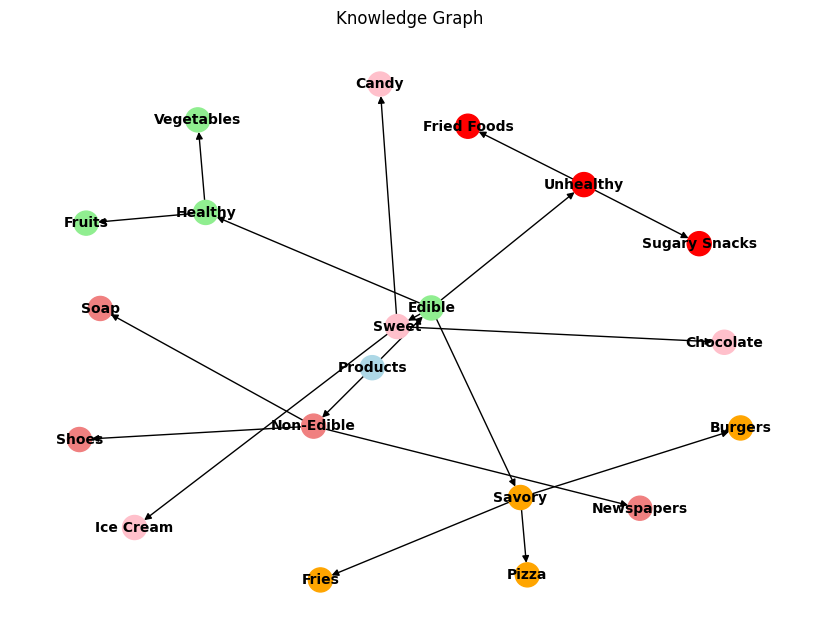

In [25]:
def visualize_graph(kg: KnowledgeGraph):
    G = nx.DiGraph()
    for node in kg.nodes:
        G.add_node(node.id, label=node.label, color=node.color)
    for edge in knowledge_graph.edges:
        G.add_edge(edge.source, edge.target, label=edge.label, color=edge.color)
    pos = nx.spring_layout(G)
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]
    edge_colors = [edge[2]['color'] for edge in G.edges(data=True)]
    labels = {node[0]: node[1]['label'] for node in G.nodes(data=True)}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_color=node_colors, edge_color=edge_colors, font_weight='bold', font_size=10)
    plt.title("Knowledge Graph")
    plt.show()

visualize_graph(knowledge_graph)

## Decision Making

## Planning and Tool-Use